# Evasion Attack: Projected Gradient Descent (PGD)

This notebook demonstrates how to perform the Projected Gradient Descent (PGD) evasion attack against our deployed MNIST digit classifier. PGD is one of the four evasion attack algorithms mentioned in the Security and Privacy of AI Knowledge Guide.

## Overview of PGD

PGD, introduced by Madry et al. in 2017, is an iterative extension of the Fast Gradient Sign Method (FGSM). Unlike FGSM which takes a single step in the direction of the gradient, PGD takes multiple smaller steps and projects the perturbation back onto an epsilon-ball (constraining the perturbation magnitude) after each step.

The mathematical formulation of each PGD iteration is:

$$x_{t+1} = \Pi_{x+S} \left( x_t + \alpha \cdot \text{sign}(\nabla_x J(\theta, x_t, y)) \right)$$

where:
- $x_t$ is the adversarial example at iteration $t$
- $\alpha$ is the step size
- $\nabla_x J$ is the gradient of the loss function with respect to the input
- $\Pi_{x+S}$ represents the projection operation back onto the $\epsilon$-ball around $x$
- $S$ is the set of allowed perturbations (typically an $L_\infty$ ball with radius $\epsilon$)

## Steps in this notebook:
1. Import required libraries
2. Set up connection to the deployed model
3. Load test data
4. Implement the PGD attack
5. Generate adversarial examples
6. Evaluate attack success rate
7. Visualize results
8. Compare with FGSM attack

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import requests
import json
import time
from tqdm.notebook import tqdm
from PIL import Image
import io
import base64

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-02-21 23:58:55.190535: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 23:58:55.433431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740182335.520815   12124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740182335.548793   12124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 23:58:55.634671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 2. Set up connection to the deployed model

We'll create functions to interact with the deployed model API.

In [2]:
# API endpoint of the deployed model
API_URL = "http://localhost:5000"

def get_model_info():
    """Get information about the deployed model"""
    response = requests.get(f"{API_URL}/info")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error fetching model info: {response.text}")

def get_prediction(pixels):
    """Get prediction for an image from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/predict_raw", json=data)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error getting prediction: {response.text}")

def get_gradient(pixels, label):
    """Get the gradient of the loss with respect to the input from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat,
        'label': int(label)
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/get_gradient", json=data)
    
    if response.status_code == 200:
        result = response.json()
        gradient = np.array(result['gradient'])
        gradient_shape = result['gradient_shape']
        return gradient.reshape(gradient_shape)
    else:
        raise Exception(f"Error getting gradient: {response.text}")
        
# Test the API connection
try:
    model_info = get_model_info()
    print("Successfully connected to the model API!")
    print(f"Model: {model_info['model_name']}")
    print(f"Input shape: {model_info['input_shape']}")
    print(f"Classes: {model_info['classes']}")
    print(f"Test accuracy: {model_info['test_accuracy']}")
except Exception as e:
    print(f"Failed to connect to the model API: {e}")
    print("Make sure the Flask server is running at http://localhost:5000")

Successfully connected to the model API!
Model: MNIST Digit Classifier
Input shape: [28, 28, 1]
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Test accuracy: 0.9905999898910522


## 3. Load Test Data

We'll load the MNIST test dataset to use for our attack.

In [5]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(_, _), (x_test, y_test) = mnist.load_data()

# Preprocess the data (normalize to 0-1)
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Loaded {len(x_test)} test images")
print(f"Data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")

Loading MNIST dataset...
Loaded 10000 test images
Data shape: (10000, 28, 28, 1)
Labels shape: (10000,)


### Examine Some Images

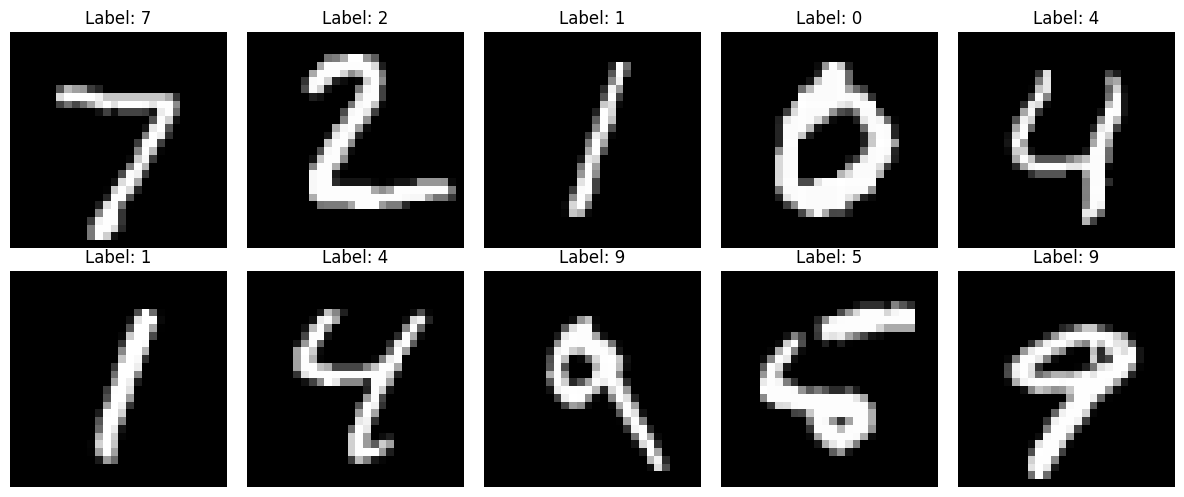

In [7]:
# Display some test images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Verify Model Predictions

Before attempting any attack, let's verify that the deployed model is correctly classifying the original images.

In [9]:
# Test model predictions on a few original images
num_test_samples = 5
test_indices = np.random.choice(len(x_test), num_test_samples, replace=False)

print("Testing model predictions on original images...")
for i, idx in enumerate(test_indices):
    # Get the image and true label
    image = x_test[idx]
    true_label = y_test[idx]
    
    # Get model prediction
    result = get_prediction(image)
    predicted_class = result['predicted_class']
    confidence = result['confidence']
    
    print(f"Sample {i+1}: True label = {true_label}, Predicted class = {predicted_class}, Confidence = {confidence:.4f}")

Testing model predictions on original images...
Sample 1: True label = 6, Predicted class = 6, Confidence = 1.0000
Sample 2: True label = 2, Predicted class = 2, Confidence = 1.0000
Sample 3: True label = 3, Predicted class = 3, Confidence = 1.0000
Sample 4: True label = 7, Predicted class = 7, Confidence = 0.9988
Sample 5: True label = 2, Predicted class = 2, Confidence = 1.0000


## 4. Implement the PGD Attack

Now, let's implement the Projected Gradient Descent (PGD) attack. The key steps are:

1. Initialize the adversarial example with the original image (optionally with small random noise)
2. For a specified number of iterations:
   a. Calculate the gradient of the loss with respect to the current adversarial example
   b. Take a step in the direction of the sign of the gradient, scaled by the step size (alpha)
   c. Project the perturbation back onto the epsilon-ball around the original image
   d. Clip the adversarial example to ensure it's within the valid range (0-1)
3. Return the final adversarial example

In [10]:
def pgd_attack(image, label, epsilon=0.1, alpha=0.01, num_iterations=40, random_start=True):
    """
    Generates an adversarial example using the Projected Gradient Descent method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Maximum perturbation magnitude (L∞ norm)
        alpha: Step size for each iteration
        num_iterations: Number of iterations to run the attack
        random_start: Whether to start with a random perturbation within the epsilon-ball
        
    Returns:
        Adversarial example
    """
    # Step 1: Initialize the adversarial example (optionally with random noise)
    if random_start:
        # Start with random noise within epsilon-ball
        noise = np.random.uniform(-epsilon, epsilon, image.shape)
        adv_image = image + noise
        adv_image = np.clip(adv_image, 0, 1)  # Ensure valid image range
    else:
        # Start with the original image
        adv_image = np.copy(image)
    
    # Step 2: Iteratively refine the adversarial example
    for i in range(num_iterations):
        # Step 2a: Calculate gradient
        gradient = get_gradient(adv_image, label)
        
        # Step 2b: Take a step in the direction of the sign of the gradient
        signed_gradient = np.sign(gradient)
        adv_image = adv_image + alpha * signed_gradient
        
        # Step 2c: Project the perturbation back onto the epsilon-ball
        perturbation = adv_image - image
        perturbation = np.clip(perturbation, -epsilon, epsilon)
        adv_image = image + perturbation
        
        # Step 2d: Clip to valid image range
        adv_image = np.clip(adv_image, 0, 1)
    
    return adv_image

## 5. Generate Adversarial Examples

Now let's generate adversarial examples for a subset of the test data using the PGD attack.

In [11]:
# Define the number of samples to attack and the attack parameters
num_samples = 20
epsilon = 0.1  # Maximum perturbation magnitude
alpha = 0.01   # Step size
num_iterations = 20  # Number of iterations

# Randomly select samples from the test set
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

# Lists to store results
original_images = []
adversarial_images = []
original_preds = []
adversarial_preds = []
true_labels = []
perturbations = []

print(f"Generating adversarial examples using PGD with:")
print(f"  - epsilon: {epsilon}")
print(f"  - alpha: {alpha}")
print(f"  - iterations: {num_iterations}")

# Generate adversarial examples
for i, idx in enumerate(tqdm(sample_indices)):
    # Get the original image and label
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    # Get original prediction
    try:
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            # Generate adversarial example
            adversarial_image = pgd_attack(
                original_image, 
                true_label, 
                epsilon=epsilon, 
                alpha=alpha, 
                num_iterations=num_iterations
            )
            
            # Calculate perturbation
            perturbation = adversarial_image - original_image
            
            # Get adversarial prediction
            adv_result = get_prediction(adversarial_image)
            adversarial_pred = adv_result['predicted_class']
            
            # Store results
            original_images.append(original_image)
            adversarial_images.append(adversarial_image)
            original_preds.append(original_pred)
            adversarial_preds.append(adversarial_pred)
            true_labels.append(true_label)
            perturbations.append(perturbation)
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue
        
# Convert lists to numpy arrays for easier handling
original_images = np.array(original_images)
adversarial_images = np.array(adversarial_images)
original_preds = np.array(original_preds)
adversarial_preds = np.array(adversarial_preds)
true_labels = np.array(true_labels)
perturbations = np.array(perturbations)

print(f"Generated {len(adversarial_images)} adversarial examples")

Generating adversarial examples using PGD with:
  - epsilon: 0.1
  - alpha: 0.01
  - iterations: 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generated 20 adversarial examples


## 6. Evaluate Attack Success Rate

Let's evaluate how successful our PGD attack was by calculating the attack success rate.

In [12]:
# Calculate attack success rate
successful_attacks = (adversarial_preds != true_labels)
attack_success_rate = np.mean(successful_attacks) * 100

print(f"Attack Success Rate: {attack_success_rate:.2f}%")
print(f"Number of successful attacks: {np.sum(successful_attacks)} out of {len(adversarial_images)}")

# Calculate average perturbation magnitude
avg_perturbation_l2 = np.mean([np.linalg.norm(p) for p in perturbations])
avg_perturbation_linf = np.mean([np.max(np.abs(p)) for p in perturbations])

print(f"Average L2 perturbation magnitude: {avg_perturbation_l2:.4f}")
print(f"Average L∞ perturbation magnitude: {avg_perturbation_linf:.4f}")

Attack Success Rate: 100.00%
Number of successful attacks: 20 out of 20
Average L2 perturbation magnitude: 1.8781
Average L∞ perturbation magnitude: 0.1000


## 7. Visualize Results

Now, let's visualize the original images, perturbations, and adversarial examples to better understand the attack.

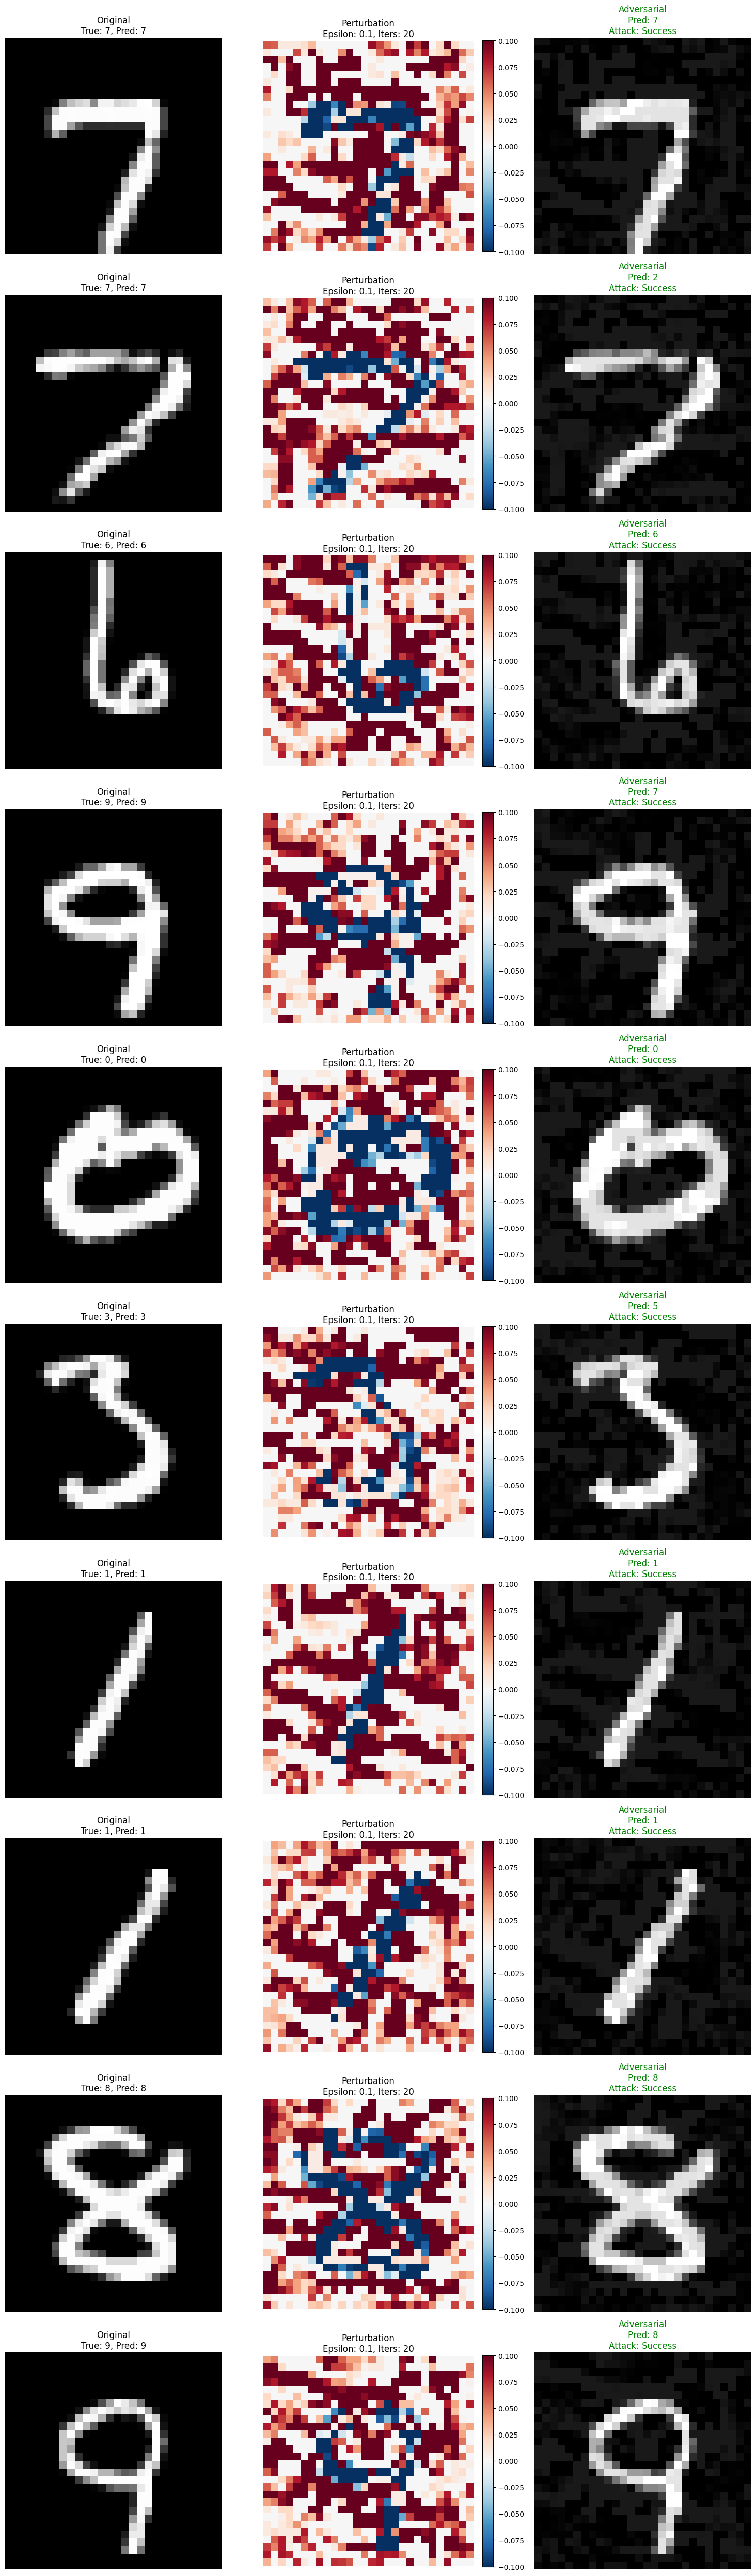

In [13]:
# Display a subset of the results
num_to_display = min(10, len(adversarial_images))

plt.figure(figsize=(15, 5 * num_to_display))

for i in range(num_to_display):
    # Original image
    plt.subplot(num_to_display, 3, 3*i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original\nTrue: {true_labels[i]}, Pred: {original_preds[i]}")
    plt.axis('off')
    
    # Perturbation
    plt.subplot(num_to_display, 3, 3*i + 2)
    plt.imshow(perturbations[i].reshape(28, 28), cmap='RdBu_r')
    plt.title(f"Perturbation\nEpsilon: {epsilon}, Iters: {num_iterations}")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(num_to_display, 3, 3*i + 3)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    color = 'green' if successful_attacks[i] else 'red'
    result = 'Success' if successful_attacks[i] else 'Failure'
    plt.title(f"Adversarial\nPred: {adversarial_preds[i]}\nAttack: {result}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 8. Analyze Attack Parameters

Let's investigate how the number of iterations affects the attack success rate while keeping epsilon fixed.

In [14]:
# Test different numbers of iterations
iteration_values = [1, 5, 10, 20, 40, 80]  # 1 iteration is equivalent to FGSM
test_samples = 10  # Use a smaller subset for efficiency
fixed_epsilon = 0.1
fixed_alpha = 0.01
success_rates = []

# Sample indices for testing
test_indices = np.random.choice(len(x_test), test_samples, replace=False)

print("Testing attack success rate for different numbers of iterations...")
print(f"Fixed epsilon: {fixed_epsilon}, Fixed alpha: {fixed_alpha}")

for iters in tqdm(iteration_values):
    successful = 0
    total = 0
    
    for idx in test_indices:
        original_image = x_test[idx]
        true_label = y_test[idx]
        
        try:
            # Get original prediction
            orig_result = get_prediction(original_image)
            original_pred = orig_result['predicted_class']
            
            # Only attack correctly classified images
            if int(original_pred) == true_label:
                # Generate adversarial example
                adversarial_image = pgd_attack(
                    original_image, 
                    true_label, 
                    epsilon=fixed_epsilon, 
                    alpha=fixed_alpha, 
                    num_iterations=iters
                )
                
                # Get adversarial prediction
                adv_result = get_prediction(adversarial_image)
                adversarial_pred = adv_result['predicted_class']
                
                # Count successful attacks
                if int(adversarial_pred) != true_label:
                    successful += 1
                total += 1
        except Exception as e:
            print(f"Error processing sample {idx} with iterations={iters}: {e}")
            continue
    
    # Calculate and store success rate
    if total > 0:
        success_rate = (successful / total) * 100
        success_rates.append(success_rate)
        print(f"Iterations: {iters}, Success Rate: {success_rate:.2f}%")
    else:
        success_rates.append(0)
        print(f"Iterations: {iters}, No valid samples")

Testing attack success rate for different numbers of iterations...
Fixed epsilon: 0.1, Fixed alpha: 0.01


  0%|          | 0/6 [00:00<?, ?it/s]

Iterations: 1, Success Rate: 0.00%
Iterations: 5, Success Rate: 0.00%
Iterations: 10, Success Rate: 0.00%
Iterations: 20, Success Rate: 10.00%
Iterations: 40, Success Rate: 10.00%
Iterations: 80, Success Rate: 10.00%


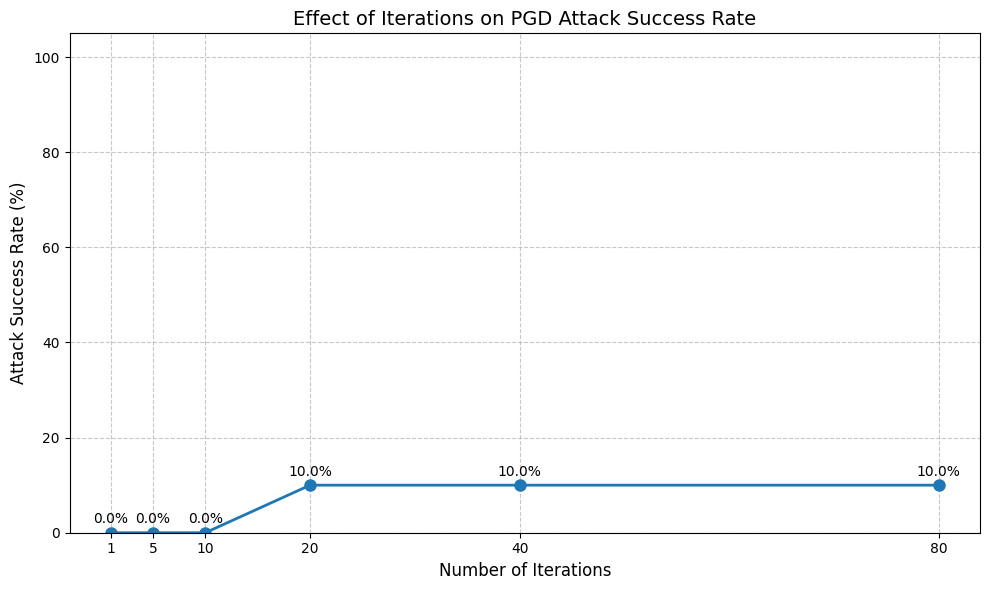

In [15]:
# Plot the relationship between number of iterations and attack success rate
plt.figure(figsize=(10, 6))
plt.plot(iteration_values, success_rates, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Attack Success Rate (%)', fontsize=12)
plt.title('Effect of Iterations on PGD Attack Success Rate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(iteration_values)
plt.ylim([0, 105])

# Add data labels
for i, rate in enumerate(success_rates):
    plt.text(iteration_values[i], rate + 2, f"{rate:.1f}%", ha='center')

plt.tight_layout()
plt.show()

### Compare the effect of random initialization

In [16]:
# Test the effect of random initialization
test_samples = 10
fixed_epsilon = 0.1
fixed_alpha = 0.01
fixed_iterations = 20

# Sample indices for testing
test_indices = np.random.choice(len(x_test), test_samples, replace=False)

# Results for random initialization (random_start=True)
print("Testing with random initialization (random_start=True)...")
random_start_success = 0
random_start_total = 0

for idx in tqdm(test_indices):
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    try:
        # Get original prediction
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            # Generate adversarial example with random start
            adversarial_image = pgd_attack(
                original_image, 
                true_label, 
                epsilon=fixed_epsilon, 
                alpha=fixed_alpha, 
                num_iterations=fixed_iterations,
                random_start=True
            )
            
            # Get adversarial prediction
            adv_result = get_prediction(adversarial_image)
            adversarial_pred = adv_result['predicted_class']
            
            # Count successful attacks
            if int(adversarial_pred) != true_label:
                random_start_success += 1
            random_start_total += 1
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue

# Results for no random initialization (random_start=False)
print("Testing without random initialization (random_start=False)...")
no_random_start_success = 0
no_random_start_total = 0

for idx in tqdm(test_indices):
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    try:
        # Get original prediction
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            # Generate adversarial example without random start
            adversarial_image = pgd_attack(
                original_image, 
                true_label, 
                epsilon=fixed_epsilon, 
                alpha=fixed_alpha, 
                num_iterations=fixed_iterations,
                random_start=False
            )
            
            # Get adversarial prediction
            adv_result = get_prediction(adversarial_image)
            adversarial_pred = adv_result['predicted_class']
            
            # Count successful attacks
            if int(adversarial_pred) != true_label:
                no_random_start_success += 1
            no_random_start_total += 1
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue

# Calculate success rates
random_start_rate = (random_start_success / random_start_total) * 100 if random_start_total > 0 else 0
no_random_start_rate = (no_random_start_success / no_random_start_total) * 100 if no_random_start_total > 0 else 0

print(f"\nSuccess rate with random initialization: {random_start_rate:.2f}%")
print(f"Success rate without random initialization: {no_random_start_rate:.2f}%")

Testing with random initialization (random_start=True)...


  0%|          | 0/10 [00:00<?, ?it/s]

Testing without random initialization (random_start=False)...


  0%|          | 0/10 [00:00<?, ?it/s]


Success rate with random initialization: 30.00%
Success rate without random initialization: 30.00%


## 9. Compare FGSM and PGD

Let's run a direct comparison between FGSM (single-step attack) and PGD (multi-step attack) on the same images.

First, let's implement the FGSM attack for comparison:

In [17]:
def fgsm_attack(image, label, epsilon=0.1):
    """
    Generates an adversarial example using the Fast Gradient Sign Method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Perturbation magnitude
        
    Returns:
        Adversarial example
    """
    # Step 1: Get the gradient of the loss with respect to the input
    gradient = get_gradient(image, label)
    
    # Step 2: Take the sign of the gradient
    sign_gradient = np.sign(gradient)
    
    # Step 3: Perturb the input in the direction of the sign of the gradient
    perturbed_image = image + epsilon * sign_gradient
    
    # Step 4: Clip the perturbed image to ensure it's within the valid range (0-1)
    perturbed_image = np.clip(perturbed_image, 0, 1)
    
    return perturbed_image

Now let's run both attacks on the same set of images:

In [18]:
# Run comparison between FGSM and PGD
comparison_samples = 10
comparison_epsilon = 0.1
pgd_alpha = 0.01
pgd_iterations = 20

# Sample indices for comparison
comp_indices = np.random.choice(len(x_test), comparison_samples, replace=False)

# Lists to store results
fgsm_success = []
pgd_success = []
fgsm_l2_norms = []
pgd_l2_norms = []

print("Comparing FGSM and PGD attacks...")
for idx in tqdm(comp_indices):
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    try:
        # Get original prediction
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            # Generate FGSM adversarial example
            fgsm_adv_image = fgsm_attack(original_image, true_label, epsilon=comparison_epsilon)
            fgsm_result = get_prediction(fgsm_adv_image)
            fgsm_pred = fgsm_result['predicted_class']
            
            # Generate PGD adversarial example
            pgd_adv_image = pgd_attack(
                original_image, 
                true_label, 
                epsilon=comparison_epsilon, 
                alpha=pgd_alpha, 
                num_iterations=pgd_iterations
            )
            pgd_result = get_prediction(pgd_adv_image)
            pgd_pred = pgd_result['predicted_class']
            
            # Record success/failure
            fgsm_success.append(int(fgsm_pred) != true_label)
            pgd_success.append(int(pgd_pred) != true_label)
            
            # Calculate L2 norms of perturbations
            fgsm_perturbation = fgsm_adv_image - original_image
            pgd_perturbation = pgd_adv_image - original_image
            
            fgsm_l2_norms.append(np.linalg.norm(fgsm_perturbation))
            pgd_l2_norms.append(np.linalg.norm(pgd_perturbation))
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue

# Calculate success rates
fgsm_success_rate = np.mean(fgsm_success) * 100 if fgsm_success else 0
pgd_success_rate = np.mean(pgd_success) * 100 if pgd_success else 0

# Calculate average L2 norms
fgsm_avg_l2 = np.mean(fgsm_l2_norms) if fgsm_l2_norms else 0
pgd_avg_l2 = np.mean(pgd_l2_norms) if pgd_l2_norms else 0

print(f"\nFGSM success rate: {fgsm_success_rate:.2f}%")
print(f"PGD success rate: {pgd_success_rate:.2f}%")
print(f"\nFGSM average L2 perturbation: {fgsm_avg_l2:.4f}")
print(f"PGD average L2 perturbation: {pgd_avg_l2:.4f}")

Comparing FGSM and PGD attacks...


  0%|          | 0/10 [00:00<?, ?it/s]


FGSM success rate: 20.00%
PGD success rate: 40.00%

FGSM average L2 perturbation: 1.9112
PGD average L2 perturbation: 1.8803


Finally, let's visualize a comparison between FGSM and PGD attacks on the same images:

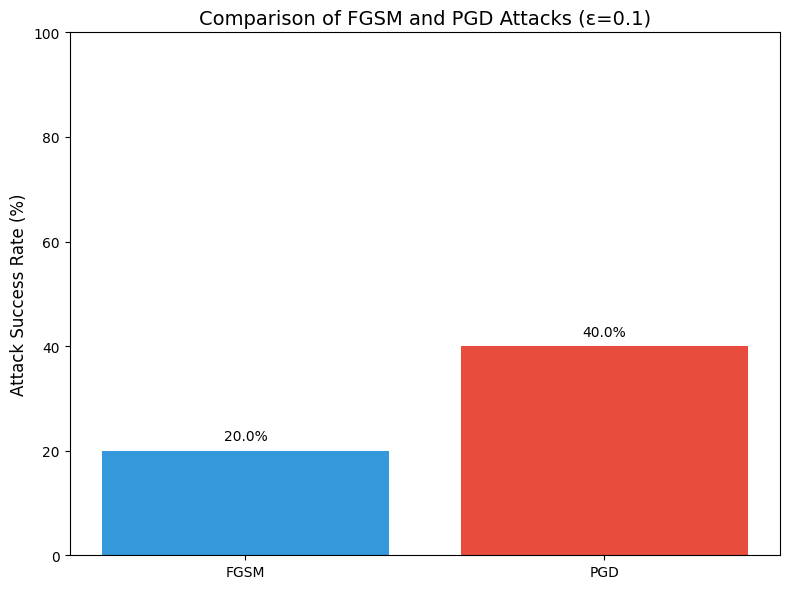

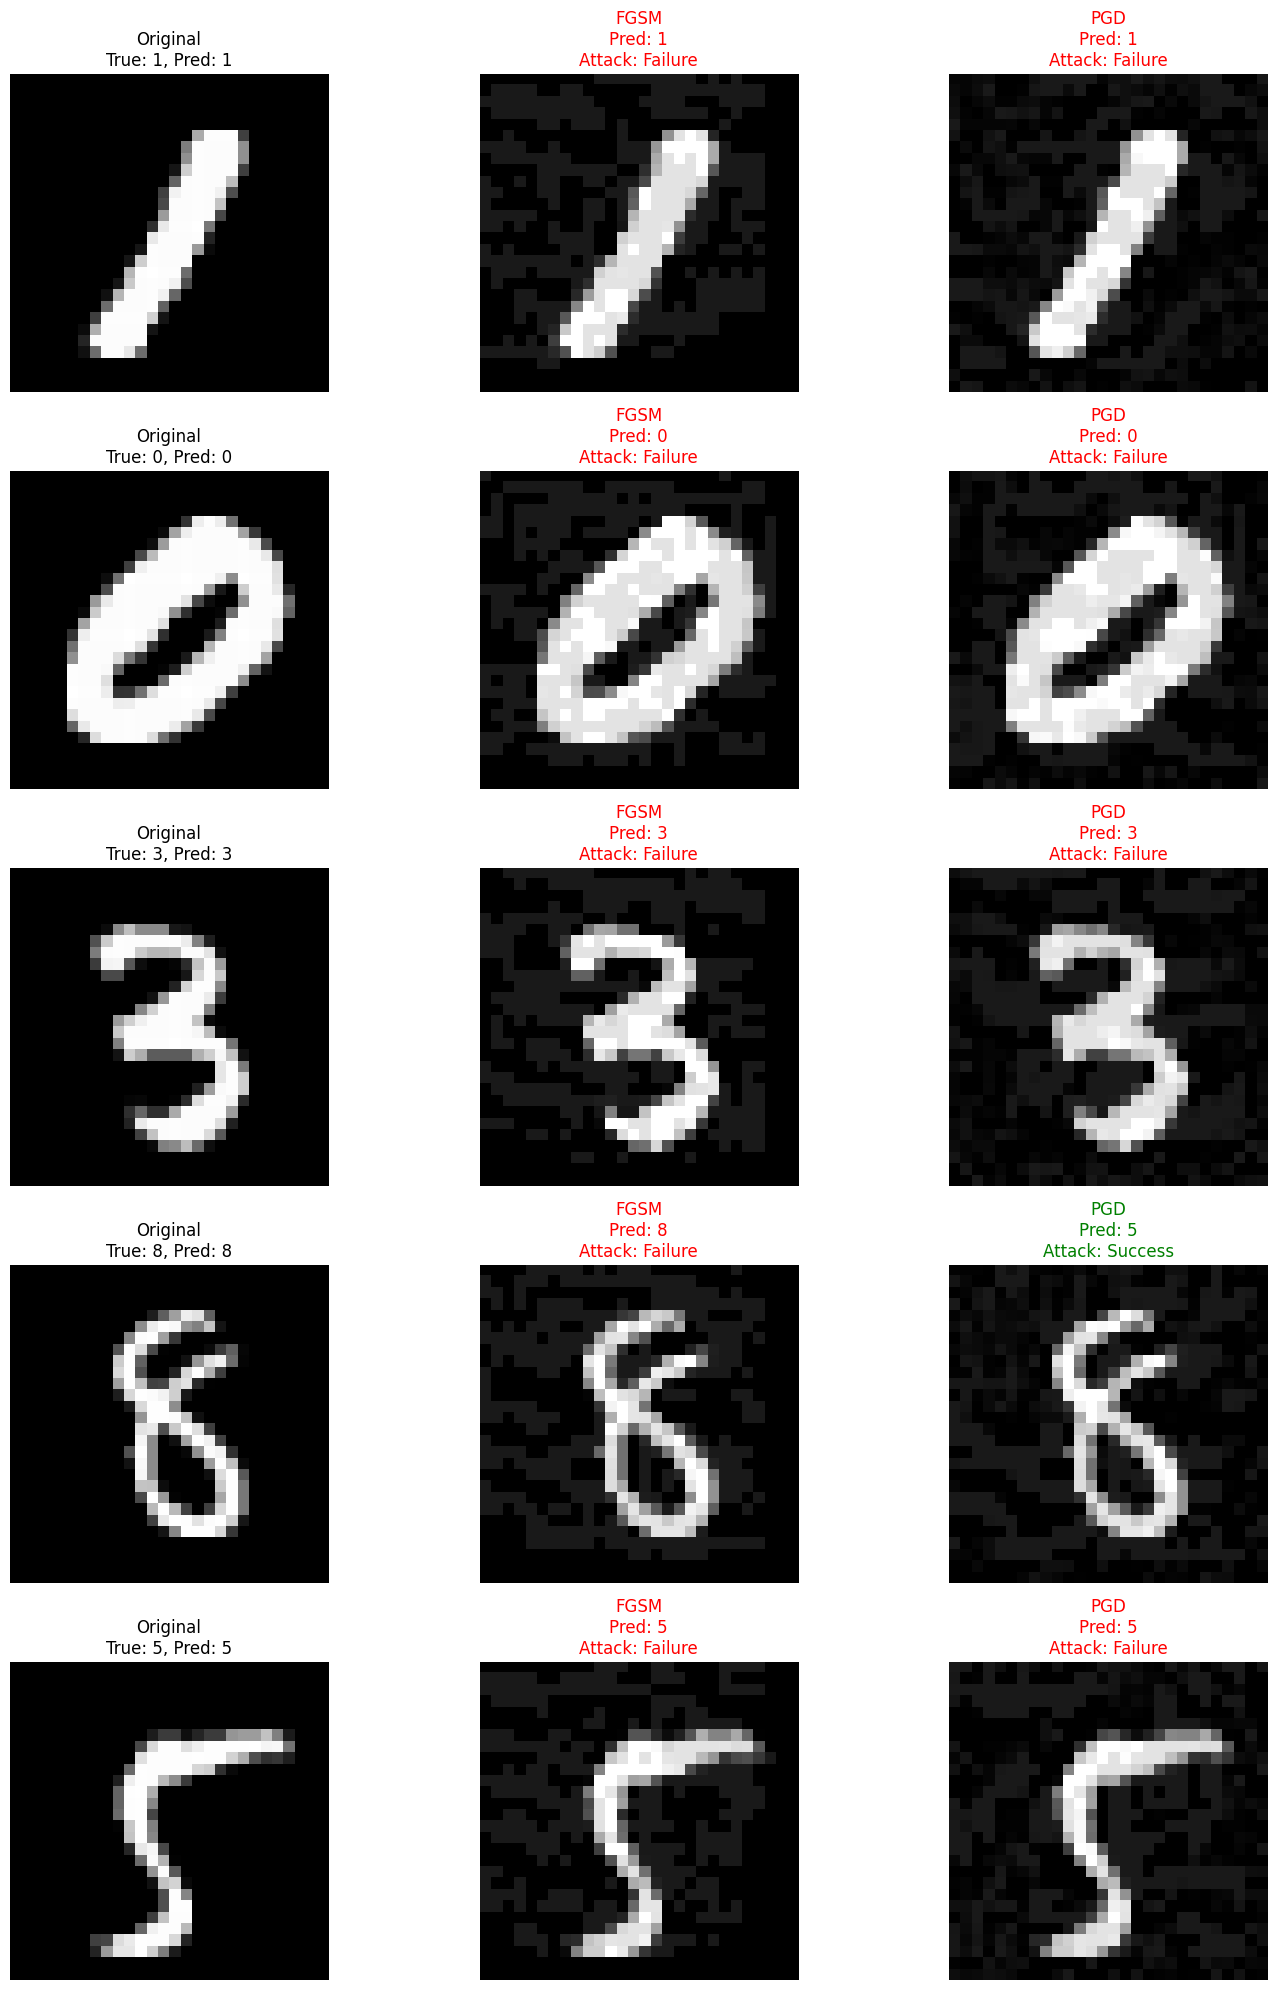

In [20]:
# Compare FGSM and PGD success rates with a bar chart
plt.figure(figsize=(8, 6))
attacks = ['FGSM', 'PGD']
success_rates = [fgsm_success_rate, pgd_success_rate]
colors = ['#3498db', '#e74c3c']

plt.bar(attacks, success_rates, color=colors)
plt.ylabel('Attack Success Rate (%)', fontsize=12)
plt.title(f'Comparison of FGSM and PGD Attacks (ε={comparison_epsilon})', fontsize=14)
plt.ylim([0, 100])

# Add data labels
for i, rate in enumerate(success_rates):
    plt.text(i, rate + 2, f"{rate:.1f}%", ha='center')

plt.tight_layout()
plt.show()

# Display a direct comparison of adversarial examples
num_to_display = min(5, len(comp_indices))
display_indices = np.random.choice(len(comp_indices), num_to_display, replace=False)

plt.figure(figsize=(15, 4 * num_to_display))

for i, idx_pos in enumerate(display_indices):
    idx = comp_indices[idx_pos]
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    # Generate FGSM and PGD adversarial examples
    fgsm_adv_image = fgsm_attack(original_image, true_label, epsilon=comparison_epsilon)
    pgd_adv_image = pgd_attack(
        original_image, 
        true_label, 
        epsilon=comparison_epsilon, 
        alpha=pgd_alpha, 
        num_iterations=pgd_iterations
    )
    
    # Get predictions
    orig_result = get_prediction(original_image)
    fgsm_result = get_prediction(fgsm_adv_image)
    pgd_result = get_prediction(pgd_adv_image)
    
    # Original image
    plt.subplot(num_to_display, 3, 3*i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    plt.title(f"Original\nTrue: {true_label}, Pred: {orig_result['predicted_class']}")
    plt.axis('off')
    
    # FGSM adversarial image
    plt.subplot(num_to_display, 3, 3*i + 2)
    plt.imshow(fgsm_adv_image.reshape(28, 28), cmap='gray')
    fgsm_color = 'green' if fgsm_result['predicted_class'] != str(true_label) else 'red'
    fgsm_result_text = 'Success' if fgsm_result['predicted_class'] != str(true_label) else 'Failure'
    plt.title(f"FGSM\nPred: {fgsm_result['predicted_class']}\nAttack: {fgsm_result_text}", color=fgsm_color)
    plt.axis('off')
    
    # PGD adversarial image
    plt.subplot(num_to_display, 3, 3*i + 3)
    plt.imshow(pgd_adv_image.reshape(28, 28), cmap='gray')
    pgd_color = 'green' if pgd_result['predicted_class'] != str(true_label) else 'red'
    pgd_result_text = 'Success' if pgd_result['predicted_class'] != str(true_label) else 'Failure'
    plt.title(f"PGD\nPred: {pgd_result['predicted_class']}\nAttack: {pgd_result_text}", color=pgd_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we have implemented and demonstrated the Projected Gradient Descent (PGD) evasion attack against a deployed MNIST digit classifier. We have:

1. Implemented the PGD attack algorithm, which is an iterative extension of FGSM
2. Generated adversarial examples that successfully fool the model
3. Evaluated the attack success rate and studied how different parameters affect it
4. Compared PGD with the simpler FGSM attack

Key findings:

1. PGD generally achieves higher attack success rates than FGSM, especially when using multiple iterations
2. The success rate of PGD increases with the number of iterations, but with diminishing returns
3. Random initialization can improve the effectiveness of PGD attacks
4. Both attacks can generate adversarial examples with perturbations that are imperceptible to humans

These results demonstrate why PGD is considered a stronger attack than FGSM. By taking multiple small steps and carefully projecting back onto the constrained perturbation space, PGD can find more effective adversarial examples that are more likely to fool the model while still maintaining the same perturbation budget (epsilon).

In real-world scenarios, defenders need to be aware of these stronger iterative attacks when designing robust models and defense mechanisms.